# Beans Disease classification: Transfer Learning

The goal is to build a robust machine learning model that is able to distinguish between diseases in the Bean plants. Beans are an important cereal food crop for Africa grown by many small-holder farmers - they are a significant source of proteins for school-age going children in East Africa.

The data is of leaf images representing 3 classes: the healthy class of images, and two disease classes including Angular Leaf Spot and Bean Rust diseases. The model should be able to distinguish between these 3 classes with high accuracy. The end goal is to build a robust, model that can be deployed on a mobile device and used in the field by a farmer.

In [7]:
#TODO: improve description (images?)

## Environment

In [8]:
# TODO: move to source files

from enum import Enum, auto

class DatasetSource(Enum):
    HUGGING_FACE = auto()
    TENSORFLOW = auto()
    KAGGLE = auto()

class BaseModel(Enum):
    XCEPTION = auto()
    EFFICIENT_NET_V2 = auto()
    MOBILE_NET = auto()

class Optimizer(Enum):
    SGD = auto()
    ADAM = auto()
    NADAM = auto()

### Configuration

In [9]:
# TODO: keep all configuration at the same place (temporarily here but eventually in config file)

PREPROCESS_IN_MODEL = False

DATASET_SOURCE = DatasetSource.TENSORFLOW
BASE_MODEL = BaseModel.XCEPTION
OPTIMIZER = Optimizer.SGD

# Same ratio as in original dataset
# TODO: use percentage in case we use datasets with different sizes
TRAIN_SIZE = 1034
VAL_SIZE = 133
TEST_SIZE = 128

BATCH_SIZE = 16
EPOCHS_PRETRAIN = 5 # 20
EPOCHS_FINETUNE = 10 # 100

### Mixed precision

In [ ]:
# WARNING: Do not use Mixed Precision for mobile - TFLite doesn't support float16 for all ops yet
# https://ai.google.dev/edge/litert/models/ops_compatibility#supported_types

# policy = tf.keras.mixed_precision.Policy("mixed_float16")
# tf.keras.mixed_precision.set_global_policy(policy)

### GPU Memory

In [11]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


### Imports

In [ ]:
import tensorflow as tf

#TODO: Download dataset from Kaggle
if (DATASET_SOURCE == DatasetSource.TENSORFLOW
    or DATASET_SOURCE == DatasetSource.KAGGLE):
    import tensorflow_datasets as tfds
elif (DATASET_SOURCE == DatasetSource.HUGGING_FACE):
    from datasets import load_dataset, concatenate_datasets

import keras
from keras.api.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Resizing, Lambda, RandomFlip, RandomRotation, RandomContrast
from keras.api.models import Sequential, Model
from keras.api.optimizers import SGD, Adam, Nadam
from keras.api.optimizers.schedules import CosineDecayRestarts
from keras.api.callbacks import EarlyStopping, TensorBoard

if (BASE_MODEL == BaseModel.XCEPTION):
    from keras.api.applications.xception import Xception, preprocess_input
elif (BASE_MODEL == BaseModel.EFFICIENT_NET_V2):
    from keras.api.applications.efficientnet_v2 import EfficientNetV2S, preprocess_input
elif (BASE_MODEL == BaseModel.MOBILE_NET):
    from keras.api.applications.mobilenet import MobileNet, preprocess_input

from sklearn.model_selection import train_test_split

import numpy as np

import collections

import matplotlib.pyplot as plt

import datetime

TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

### Versions

Check versions for compatibility issues.

In [ ]:
# TODO: requirements file should be enough and could replace this

from importlib.metadata import version

def print_version(module_name):
    print(f"{module_name}: {version(module_name)}")

print_version("tensorflow")
print_version("keras")
print_version("scikit-learn")
print_version("numpy")

tensorflow: 2.18.0
keras: 3.9.0
scikit-learn: 1.5.1
numpy: 1.26.4


In [ ]:
!nvidia-smi

Mon May 26 09:34:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 572.16         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro P600                    On  |   00000000:01:00.0 Off |                  N/A |
| N/A   66C    P0             N/A / 5001W |      33MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Wed_Jan_15_19:20:09_PST_2025
Cuda compilation tools, release 12.8, V12.8.61
Build cuda_12.8.r12.8/compiler.35404655_0


### Determinism

Make sure every run is deterministic so that results are reproducible and improvements verified.

In [ ]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
# TODO: this is causing heavy performance hit - see how much different are results without it
# tf.config.experimental.enable_op_determinism()

In [11]:
start_time = datetime.datetime.now()

## Loading data

Load everything so that we can split it ourselves.

In [12]:
if (DATASET_SOURCE == DatasetSource.TENSORFLOW
    or DATASET_SOURCE == DatasetSource.KAGGLE):
    ds, info = tfds.load(
        "beans",
        split="all",
        with_info=True,
        shuffle_files=True,
        as_supervised=True,
    )
    ds_all = tfds.as_dataframe(ds, info)
    ds_all_images = ds_all["image"]
    ds_all_labels = ds_all["label"]

    n_classes = info.features["label"].num_classes
    class_names = info.features["label"].names

elif (DATASET_SOURCE == DatasetSource.HUGGING_FACE):
    ds = load_dataset("AI-Lab-Makerere/beans")
    ds_all = concatenate_datasets([ds["train"], ds["validation"], ds["test"]])
    ds_all_images = ds_all["image"]
    ds_all_labels = ds_all["labels"]

    class_names = ["angular_leaf_spot", "bean_rust", "healthy"]
    n_classes = len(class_names)


2025-05-26 09:34:56.074165: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-26 09:34:57.002106: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Stratified split

Original split caused huge difference in performance of model when doing predictions with validation and test data sets.

In [13]:
train_data, temp_data, train_labels, temp_labels = train_test_split(
    ds_all_images,
    ds_all_labels,
    train_size=TRAIN_SIZE,
    random_state=42,
    shuffle=True,
    stratify=ds_all_labels,
)

val_data, test_data, val_labels, test_labels = train_test_split(
    temp_data,
    temp_labels,
    train_size=VAL_SIZE,
    random_state=42,
    shuffle=True,
    stratify=temp_labels,
)

ds_train = tf.data.Dataset.from_tensor_slices((np.array(train_data.tolist()), np.array(train_labels.tolist())))
ds_valid = tf.data.Dataset.from_tensor_slices((np.array(val_data.tolist()), np.array(val_labels.tolist())))
ds_test = tf.data.Dataset.from_tensor_slices((np.array(test_data.tolist()), np.array(test_labels.tolist())))

Make sure original ratio is preserved.

In [14]:
print(f"train set {len(list(ds_train))}")
print(f"validation set {len(list(ds_valid))}")
print(f"test set {len(list(ds_test))}")

train set 1034
validation set 133
test set 128


2025-05-26 09:34:59.690771: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-05-26 09:34:59.813641: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Make sure that ratio of different classes is same across datasets

In [15]:
def count_labels(dataset):
    label_counts = collections.Counter()

    for _, label in dataset:
        label_counts[label.numpy()] += 1

    total_count = sum(label_counts.values())
    label_ratios = {label: count / total_count for label, count in label_counts.items()}
    
    sorted_label_ratios = dict(sorted(label_ratios.items()))

    return sorted_label_ratios

print(count_labels(ds_train))
print(count_labels(ds_valid))
print(count_labels(ds_test))

{0: 0.33365570599613154, 1: 0.3365570599613153, 2: 0.32978723404255317}
{0: 0.3308270676691729, 1: 0.3383458646616541, 2: 0.3308270676691729}
{0: 0.3359375, 1: 0.3359375, 2: 0.328125}


## Preprocess and Augmentation

In [36]:
preprocess = Sequential([
    Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    Lambda(preprocess_input)
])

# TODO: instead of augmenting existing sample - try creating new ones with augmentation
# (not too many since that can cause overfitting as well)
# TODO: test more augmentations (that make sense) and different parameters (e.g. zoom, brightness, noise)
preprocess_and_augmentation = Sequential([
    Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    RandomFlip(mode="horizontal", seed=42),
    RandomRotation(factor=0.05, seed=42),
    RandomContrast(factor=0.2, seed=42),
    Lambda(preprocess_input)
])
augmentation = Sequential([
    RandomFlip(mode="horizontal", seed=42),
    RandomRotation(factor=0.05, seed=42),
    RandomContrast(factor=0.2, seed=42),
])

resizing_and_augmentation = Sequential([
    Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    RandomFlip(mode="horizontal", seed=42),
    RandomRotation(factor=0.05, seed=42),
    RandomContrast(factor=0.2, seed=42)
])

## Input pipeline

Preprocess and augmentation is part of input pipeline because it is faster.

When processing power / time is not an issue, I recommend moving it to model.
Apart from cleaner and more flexible code, having it as part of model actually improved performance a bit.

In [17]:
if (not PREPROCESS_IN_MODEL):
    ds_train = ds_train.map(
        lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache("cache_train")
ds_train = ds_train.shuffle(TRAIN_SIZE)
if (not PREPROCESS_IN_MODEL):
    ds_train = ds_train.map(
        lambda X, y: (augmentation(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [18]:
if (not PREPROCESS_IN_MODEL):
    ds_valid = ds_valid.map(
        lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.cache("cache_val")
ds_valid = ds_valid.batch(BATCH_SIZE)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

In [19]:
if (not PREPROCESS_IN_MODEL):
    ds_test = ds_test.map(
        lambda X, y: (preprocess(X), y), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.cache("cache_test")
ds_test = ds_test.batch(BATCH_SIZE)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

Verify that augmentation produces photos similar to original dataset (too much augmentation might cause model not to generalize well).

In [20]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in ds_train.take(1):
    # TODO: make sure we get clear augmented and original images even if preprocessing in model
    # X_batch = resizing_and_augmentation(X_batch)
    # X_batch = preprocess_input(X_batch)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

2025-05-26 09:35:01.435305: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1200x1200 with 9 Axes>

## Base model with pre-trained weights

TODO: Create a separate README for experiment results / conclusions

Xception with SGD optimizer converges pretty quickly with good results (other models needed more time with lower learning to achieve same performance).

This version mostly follows example from [Machine Learning Notebooks, 3rd edition](https://github.com/ageron/handson-ml3).

In [ ]:
if BASE_MODEL == BaseModel.XCEPTION:
    base_model = Xception(input_shape=(224, 224, 3), include_top=False)
elif BASE_MODEL == BaseModel.EFFICIENT_NET_V2:
    base_model = EfficientNetV2S(input_shape=(224, 224, 3), include_top=False)
elif BASE_MODEL == BaseModel.MOBILE_NET:
    base_model = MobileNet(input_shape=(224, 224, 3), include_top=False)

This simple top performs surprisingly well (however Dropout is needed for overfitting). 

Adding additional Dense layer, Batch Normalization layer and/or Dropout layer required more hyperparameter tuning to get similar performance (but never as good.).

In [22]:
if (PREPROCESS_IN_MODEL):
    inputs = Input(shape=(None, None, 3))
    x = resizing_and_augmentation(inputs)
    x = preprocess_input(x)
    x = base_model(x, training=False)
else:
    inputs = base_model.input
    x = base_model.output

x = GlobalAveragePooling2D()(x)
# TODO: test different dropout
x = Dropout(0.5)(x)

# TODO: test kernel_regularizer
outputs = Dense(n_classes, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs)

Since we are using base_model layers directly (base_model.output), we need to iterate through all of them and switch training off.

In [23]:
# When preprocessing is done in model, we do not need to set trainable flag per base layer
if PREPROCESS_IN_MODEL:
    base_model.trainable = False
else:
    for layer in base_model.layers:
        layer.trainable = False

## Initial training without touching base model

Early stopping is here in this version more to make sure that the best weights are used.

In different versions where we needed to train for longer, it also helped us to end early when there was not progress (and avoid overfitting).

In [24]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, mode="min"
)

In [25]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="model_checkpoint.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

SGD works surprisingly well - doesn't use as much memory, converges fast and with good results.

Adam required more training and had bigger memory footprint with much smaller learning rate (and/or learning rate scheduler).

In [26]:
if Optimizer.SGD:
    optimizer = SGD(learning_rate=0.1, momentum=0.9)
elif Optimizer.Adam:
    optimizer = Adam()
elif OPTIMIZER == Optimizer.NADAM:
    optimizer = Nadam(learning_rate=1e-4)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [27]:
import gc
import psutil

class RAMMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()  # Force garbage collection
        ram_percent = psutil.virtual_memory().percent
        print(f"Epoch {epoch}: RAM usage {ram_percent:.1f}%")

In [28]:
history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS_PRETRAIN,
    callbacks=[early_stopping, model_checkpoint_callback, RAMMonitor()],
)

Epoch 1/5


I0000 00:00:1748244909.850414   21879 service.cc:148] XLA service 0x7faa0c002740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748244909.850482   21879 service.cc:156]   StreamExecutor device (0): Quadro P600, Compute Capability 6.1
2025-05-26 09:35:10.019904: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748244910.834001   21879 cuda_dnn.cc:529] Loaded cuDNN version 90700
2025-05-26 09:35:14.968964: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-26 09:35:16.265333: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory t

64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.4963 - loss: 2.4139

2025-05-26 09:35:52.680011: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.11GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-26 09:35:53.687651: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.21GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.4973 - loss: 2.4233Epoch 0: RAM usage 48.8%
65/65 ━━━━━━━━━━━━━━━━━━━━ 74s 822ms/step - accuracy: 0.4984 - loss: 2.4323 - val_accuracy: 0.5038 - val_loss: 7.1983
Epoch 2/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6702 - loss: 3.8568Epoch 1: RAM usage 50.7%
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 399ms/step - accuracy: 0.6704 - loss: 3.8556 - val_accuracy: 0.5414 - val_loss: 5.4289
Epoch 3/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7352 - loss: 3.1549Epoch 2: RAM usage 52.0%
65/65 ━━━━━━━━━━━━━━━━━━━━ 26s 398ms/step - accuracy: 0.7350 - loss: 3.1572 - val_accuracy: 0.5489 - val_loss: 6.7289
Epoch 4/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7128 - loss: 3.5928Epoch 3: RAM usage 52.4%
65/65 ━━━━━━━━━━━━━━━━━━━━ 27s 410ms/step - accuracy: 0.7133 - loss: 3.5844 - val_accuracy: 0.6090 - val_loss: 4.6490
Epoch 5/5
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7451 - loss: 2.8673Epoch 4: RAM usage

In [29]:
restored_epoch = early_stopping.best_epoch + 1 # EarlyStopping uses 0-based indexing (from observation)
restored_epoch

5

In [30]:
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

8/8 - 3s - 357ms/step - accuracy: 0.6484 - loss: 4.4155
0.6484375


In [31]:
acc_history = history.history["accuracy"]
val_acc_history = history.history["val_accuracy"]

loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]

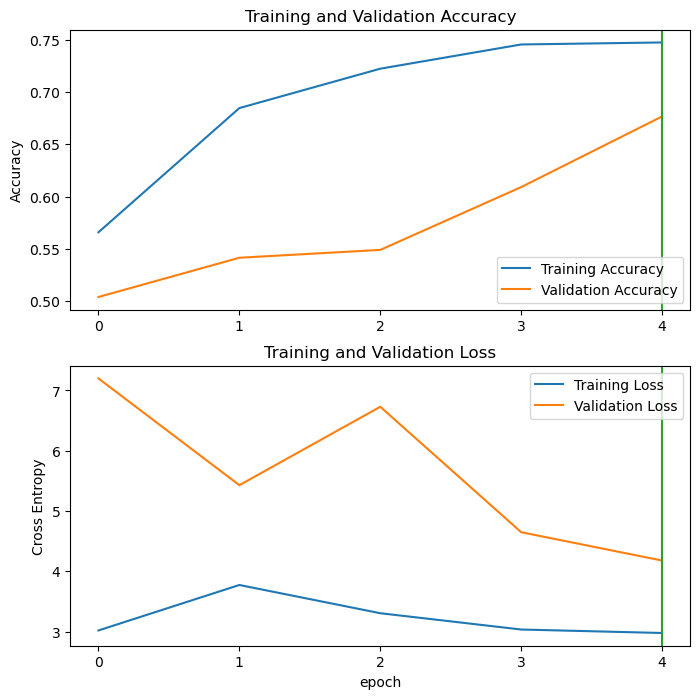

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xticks(range(100))
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.plot([restored_epoch - 1, restored_epoch - 1], plt.ylim(), label="Best weights")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.legend(loc="upper right")
plt.xticks(range(100))
plt.ylabel("Cross Entropy")
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.plot([restored_epoch - 1, restored_epoch - 1], plt.ylim(), label="Best weights")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

## Fine tuning

Same as before - early stopping is used mostly to get best weights.

Using bigger number for patience as we fine tune for longer.

In [34]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, mode="min"
)

# TensorBoard Callback (repeating here to have unique timestamp)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [35]:
# TODO: test different learning rate schedules (e.g. one cycle scheduler, ReduceLROnPlateau)
lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-4,  # Adjust if needed
    first_decay_steps=20,        # Increased from 10
    t_mul=2.0,                   # You can try increasing this
    m_mul=1.0,                   # You can experiment with values < 1.0
    alpha=0.0                    # Adjust if needed
)

Unfreeze some layers from base_model for fine tuning. We also need to use much lower learning rate so that existing weights are not completely destroyed.

In [36]:
if PREPROCESS_IN_MODEL:
    base_model.trainable = True

    for layer in base_model.layers[:-226]:
        layer.trainable = False
else:
    for layer in base_model.layers[56:]:
        layer.trainable = True

if OPTIMIZER == Optimizer.SGD:
    # TODO: test lr schedule for SGD as well (different learning rates though)
    optimizer = SGD(learning_rate=0.01, momentum=0.9)
elif OPTIMIZER == Optimizer.ADAM:
    optimizer = Adam(learning_rate=lr_schedule)
elif OPTIMIZER == Optimizer.NADAM:
    # TODO: test lr schedule for NADAM as well (different learning rates though)
    optimizer = Nadam(learning_rate=1e-4)

model.compile(
    loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
)

In [37]:
history_fine = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS_FINETUNE,
    callbacks=[early_stopping, tensorboard_callback, model_checkpoint_callback, RAMMonitor()],
)

Epoch 1/10


2025-05-26 09:38:26.337554: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-26 09:38:27.788542: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-26 09:38:27.788676: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-05-26 09:38:28.951213: W external/local_xla/xla/ts

64/65 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.6126 - loss: 1.9774

2025-05-26 09:39:34.120326: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_add_divide_reduce_fusion_1', 8 bytes spill stores, 16 bytes spill loads



65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.6127 - loss: 1.9670Epoch 0: RAM usage 54.6%
65/65 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6128 - loss: 1.9570 - val_accuracy: 0.7068 - val_loss: 1.0409
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.8327 - loss: 0.4600Epoch 1: RAM usage 56.4%
65/65 ━━━━━━━━━━━━━━━━━━━━ 47s 710ms/step - accuracy: 0.8332 - loss: 0.4591 - val_accuracy: 0.7744 - val_loss: 0.7968
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9202 - loss: 0.2761Epoch 2: RAM usage 57.9%
65/65 ━━━━━━━━━━━━━━━━━━━━ 48s 733ms/step - accuracy: 0.9203 - loss: 0.2753 - val_accuracy: 0.8647 - val_loss: 0.3981
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.9317 - loss: 0.1972Epoch 3: RAM usage 56.6%
65/65 ━━━━━━━━━━━━━━━━━━━━ 46s 693ms/step - accuracy: 0.9318 - loss: 0.1968 - val_accuracy: 0.7293 - val_loss: 0.9741
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.9597 - loss: 0.1439Epoch 4: RAM usag

In [38]:
restored_epoch_fine = early_stopping.best_epoch + 1 # EarlyStopping uses 0-based indexing (from observation)
restored_epoch_fine

3

In [39]:
train_loss, train_acc = model.evaluate(ds_train, verbose=2)
print(train_acc)

65/65 - 26s - 403ms/step - accuracy: 0.9110 - loss: 0.2496
0.9110251665115356


In [40]:
val_loss, val_acc = model.evaluate(ds_valid, verbose=2)
print(val_acc)

9/9 - 2s - 171ms/step - accuracy: 0.8647 - loss: 0.3981
0.8646616339683533


In [41]:
test_loss, test_acc = model.evaluate(ds_test, verbose=2)
print(test_acc)

8/8 - 3s - 338ms/step - accuracy: 0.9453 - loss: 0.1782
0.9453125


Dismiss history that was not used (Early Stopping)

In [42]:
acc_history = acc_history[:restored_epoch]
val_acc_history = val_acc_history[:restored_epoch]

loss_history = loss_history[:restored_epoch]
val_loss_history = val_loss_history[:restored_epoch]

In [43]:
acc_history += history_fine.history["accuracy"]
val_acc_history += history_fine.history["val_accuracy"]

loss_history += history_fine.history["loss"]
val_loss_history += history_fine.history["val_loss"]

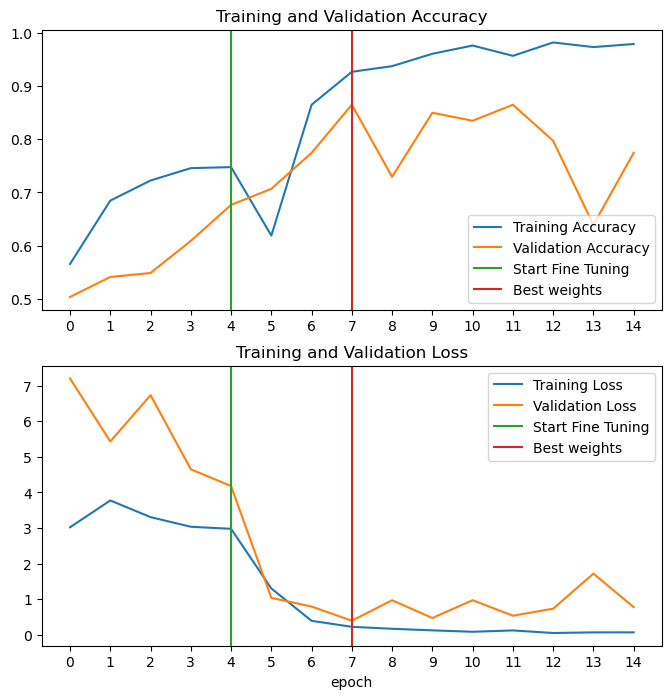

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc_history, label="Training Accuracy")
plt.plot(val_acc_history, label="Validation Accuracy")
plt.xticks(range(100))
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.plot(
    [restored_epoch - 1, restored_epoch - 1], plt.ylim(), label="Start Fine Tuning"
)
plt.plot(
    [
        restored_epoch + restored_epoch_fine - 1,
        restored_epoch + restored_epoch_fine - 1,
    ],
    plt.ylim(),
    label="Best weights",
)
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss_history, label="Training Loss")
plt.plot(val_loss_history, label="Validation Loss")
plt.xticks(range(100))
plt.ylim([min(plt.ylim()), max(plt.ylim())])
plt.plot(
    [restored_epoch - 1, restored_epoch - 1], plt.ylim(), label="Start Fine Tuning"
)
plt.plot(
    [
        restored_epoch + restored_epoch_fine - 1,
        restored_epoch + restored_epoch_fine - 1,
    ],
    plt.ylim(),
    label="Best weights",
)
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

## Save model

In [45]:
model.save("beans_disease_classification_transfer_learning.keras")

In [46]:
duration = datetime.datetime.now() - start_time
print(duration)

0:12:23.461889


## Verify that config prevailed

In [47]:
tf.keras.mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

In [48]:
for gpu in tf.config.list_physical_devices('GPU'):
    print(gpu)
    if tf.config.experimental.get_device_details(gpu):
        print(tf.config.experimental.get_device_details(gpu))

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
{'compute_capability': (6, 1), 'device_name': 'Quadro P600'}


In [49]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    print(f"Memory growth enabled: {tf.config.experimental.get_memory_growth(gpus[0])}")
    
    # Also check current memory usage
    try:
        memory_info = tf.config.experimental.get_memory_info('GPU:0')
        print(f"Current: {memory_info['current']/1024**3:.2f}GB")
        print(f"Peak: {memory_info['peak']/1024**3:.2f}GB")
    except:
        print("Memory info not available during execution")

Memory growth enabled: True
Current: 1.07GB
Peak: 1.59GB


## Prepare model for mobile

In [15]:
model = keras.models.load_model("beans_disease_classification_transfer_learning.keras")

/home/martin/miniconda/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'SGD', because it has 95 variables whereas the saved optimizer has 99 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Test Model on Samples

Found 5 sample images: ['angular_leaf_spot_01.jpg', 'bean_rust_01.jpg', 'healthy_01.jpg', 'mobile_bean_rust.png', 'plane.jpg']

--- angular_leaf_spot_01.jpg ---
True label: Angular Leaf
Predicted label: Angular Leaf
Confidence: 1.0000
Correct: ✓
Prediction probabilities:
  Angular Leaf: 1.0000
  Bean Rust: 0.0000
  Healthy: 0.0000

--- bean_rust_01.jpg ---
True label: Bean Rust
Predicted label: Bean Rust
Confidence: 1.0000
Correct: ✓
Prediction probabilities:
  Angular Leaf: 0.0001
  Bean Rust: 1.0000
  Healthy: 0.0000

--- healthy_01.jpg ---
True label: Healthy
Predicted label: Healthy
Confidence: 1.0000
Correct: ✓
Prediction probabilities:
  Angular Leaf: 0.0000
  Bean Rust: 0.0000
  Healthy: 1.0000

--- mobile_bean_rust.png ---
True label: Unknown
Predicted label: Bean Rust
Confidence: 1.0000
Correct: ✗
Prediction probabilities:
  Angular Leaf: 0.0000
  Bean Rust: 1.0000
  Healthy: 0.0000

--- plane.jpg ---
True label: Unknown
Predicted label: Angular Leaf
Confidence: 0.5449
Correct

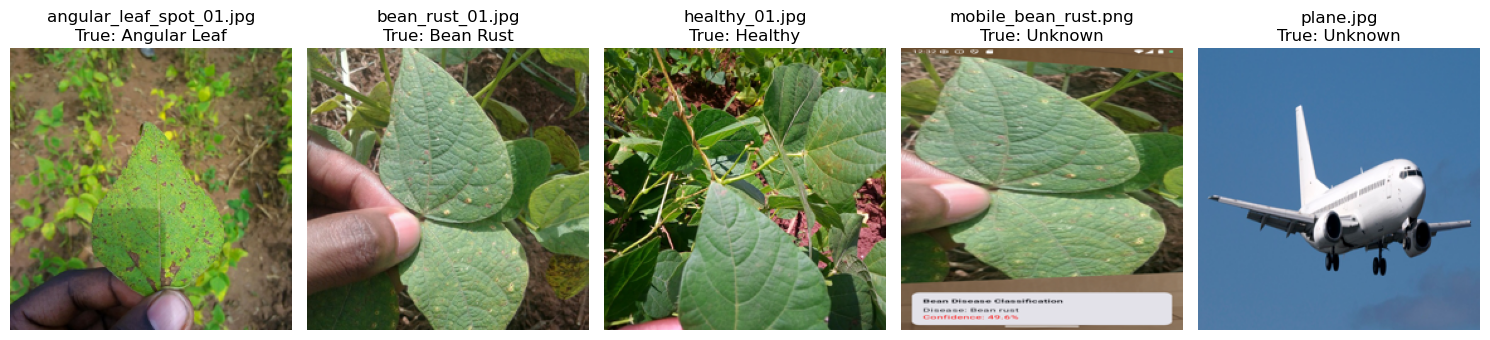

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np

class_names = {
    0 : "Angular Leaf",
    1 : "Bean Rust",
    2 : "Healthy"
}

# Path to local samples
samples_dir = "hugging_face/samples"

# Get all sample images
sample_files = [f for f in os.listdir(samples_dir) if f.endswith(('.jpg', '.png'))]
sample_files.sort()  # Sort for consistent ordering

print(f"Found {len(sample_files)} sample images: {sample_files}")

# Create a mapping from filename to expected class
filename_to_class = {
    "angular_leaf_spot_01.jpg": 0,  # angular_leaf_spot
    "bean_rust_01.jpg": 1,          # bean_rust  
    "healthy_01.jpg": 2,             # healthy
}

# Test inference on all sample images
fig, axes = plt.subplots(1, len(sample_files), figsize=(15, 5))
if len(sample_files) == 1:
    axes = [axes]

for idx, filename in enumerate(sample_files):
    # Load image
    img_path = os.path.join(samples_dir, filename)
    sample_image = Image.open(img_path).convert("RGB")
    true_label = filename_to_class.get(filename, -1)
    
    # Resize image to model input size
    sample_image_resized = sample_image.resize((224, 224))
    
    # Display the image
    axes[idx].imshow(sample_image_resized)
    axes[idx].set_title(f"{filename}\nTrue: {class_names[true_label] if true_label != -1 else 'Unknown'}")
    axes[idx].axis("off")
    
    # Preprocess for inference
    img_array = np.array(sample_image_resized)
    img_batch = np.expand_dims(img_array, axis=0)
    
    # Apply preprocessing
    preprocessed_img = preprocess(img_batch)
    
    # Perform inference
    predictions = model.predict(preprocessed_img, verbose=0)
    predicted_class = np.argmax(predictions[0])
    confidence = np.max(predictions[0])
    
    print(f"\n--- {filename} ---")
    print(f"True label: {class_names[true_label] if true_label != -1 else 'Unknown'}")
    print(f"Predicted label: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Correct: {'✓' if predicted_class == true_label else '✗'}")
    print(f"Prediction probabilities:")
    for i, prob in enumerate(predictions[0]):
        print(f"  {class_names[i]}: {prob:.4f}")

plt.tight_layout()
plt.show()

### Convert to TFLite

In [ ]:
# Convert Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Enable optimizations for smaller model size
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Force float32 input/output types for compatibility
converter.target_spec.supported_types = [tf.float32]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Enable Select TF Ops fallback for unsupported ops (required for Xception)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
    tf.lite.OpsSet.SELECT_TF_OPS     # enable TensorFlow ops.
]

tflite_model = converter.convert()

# Save the TFLite model
with open('beans_disease_classification_transfer_learning.tflite', 'wb') as f:
    f.write(tflite_model)

print(f"TensorFlow Lite model saved as 'beans_disease_classification_transfer_learning.tflite'")
print(f"Model size: {len(tflite_model) / 1024 / 1024:.2f} MB")

INFO:tensorflow:Assets written to: /tmp/tmpq5x5lv4y/assets


INFO:tensorflow:Assets written to: /tmp/tmpq5x5lv4y/assets


Saved artifact at '/tmp/tmpq5x5lv4y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  131405005176080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131405005175504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131405005176656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131405005175120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131405005175888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131405005175312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131405005173584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131405005173200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131405005174352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131405005173776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  131405005173392

W0000 00:00:1758277075.882104    7072 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1758277075.882501    7072 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-09-19 12:17:55.885071: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpq5x5lv4y
2025-09-19 12:17:55.915945: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-09-19 12:17:55.915999: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpq5x5lv4y
2025-09-19 12:17:56.315096: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-09-19 12:17:58.388283: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpq5x5lv4y
2025-09-19 12:17:58.830178: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 2945054 microseconds.
2025-09-19 12:18:03.928305: W tensorflow/co

TensorFlow Lite model saved as 'beans_disease_classification_transfer_learning.tflite'
Model size: 39.89 MB
